In [226]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [227]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [228]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [229]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [230]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    print(num_serv_that_meet_deadline.shape)
    num_serv_that_meet_deadline = np.sort(num_serv_that_meet_deadline, axis=0)
    end = int(np.round(0.01*num_serv_that_meet_deadline.shape[0]))
#     print(end)
    res_99 = np.mean(num_serv_that_meet_deadline[:end])
#     print(num_serv_that_meet_deadline[:end])
    return np.mean(num_serv_that_meet_deadline), res_99

In [231]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [232]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [233]:
def load_data(path, delimiter, start_time, main_col, target_length=-1):
    # remove any leading or trailing 0s based on the main information column    
    data = np.genfromtxt(path, delimiter=delimiter)
    if data.ndim == 1:
        data = data.reshape((data.shape[0],1))
#     print("initial data shape ", data.shape)
#     print("initial first time ", data[0,0])
#     print("initial last time ", data[data.shape[0]-1,0]) 
    tmp = np.trim_zeros(data[:,main_col], trim='b')
    data = data[:tmp.shape[0],:]
    tmp = np.trim_zeros(data[:,main_col], trim='f')
    data = data[data.shape[0] - tmp.shape[0]:,:]
    
    data = data[data[:,0]>=start_time]
    if target_length != -1:
        data = data[data.shape[0]-target_length:,:]
#     print("data shape ", data.shape)
#     print("first time ", data[0,0])
#     print("last time ", data[data.shape[0]-1,0])  
    
    return data

In [234]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

In [235]:
results_folders = ["/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()

deadline = 1


for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

## Fanout, workload 0 with gamma + background traffic at 200Mbps - 40 flows 

In [236]:
simul_folder = "gamma_bkg200_fanout_wkld6_3_40flows"
stable_state_offset = 14
for folder in results_folders:
    path = simul_folder + folder
#     q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
#     bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
#     bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
#     fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
#     fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,190)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,14592)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,107)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(26223,)
/DCTCP30/
Mean Q length in Kbytes 5.54519527706675 and in packets 6.656253292685766
99th percentile in Kbytes 33.22026856223924 and in packets 43.9107467605959

Mean delay in us 44.361562216534 and 99th percentile delay in us 265.7621484979139

Background FCT (ms): mean: 98.28916795843853, 99th %: 196.43086524886618

Fanout max QCT (ms): mean: 0.620778617337071, 99th %: 1.236087471403948

Fanout avg QCT (ms): mean: 0.20039942586108253, 99th %: 0.5100064598659839

Fanout min QCT (ms): mean: 0.07956421835526507, 99th %: 0.35066961157014015

Servers in deadline: mean: 39.943637264996376, 99th %: 38.412213740458014

(26223,)
/DCTCP_pacer_PQ/
Mean Q length in Kbytes 0.03480435813293394 and in packets 0.07660822186289766
99th percentile in Kbytes 0.730230294645683 and in packets 0.9614289233073137

Mean delay in us 0.27843486506347154 and 99th percentile delay in us 5.841842357165463

Background FCT (ms): mean: 198.83661698687462, 99th %: 263.7304463047525

Fanout max QCT (ms): mean

## Fanout, workload 0 with gamma + background traffic at 400Mbps - 40 flows 

In [237]:
simul_folder = "gamma_bkg400_fanout_wkld6_3_40flows"
stable_state_offset = 7.5
for folder in results_folders:
    path = simul_folder + folder
#     q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
#     bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
#     bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
#     fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
#     fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1028)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38172)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,544)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,68)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(28210,)
/DCTCP30/
Mean Q length in Kbytes 11.134165530306843 and in packets 13.333360397466144
99th percentile in Kbytes 34.27158264628534 and in packets 44.825332686928576

Mean delay in us 89.07332424245475 and 99th percentile delay in us 274.1726611702827

Background FCT (ms): mean: 136.15224552252192, 99th %: 572.6059075790422

Fanout max QCT (ms): mean: 0.6687923699896299, 99th %: 1.303614155424171

Fanout avg QCT (ms): mean: 0.24940260639088332, 99th %: 0.5351377834327207

Fanout min QCT (ms): mean: 0.12494214759246934, 99th %: 0.37283083060206224

Servers in deadline: mean: 39.922545196738746, 99th %: 38.223404255319146

(28210,)
/DCTCP_pacer_PQ/
Mean Q length in Kbytes 0.32757953362914644 and in packets 0.44469452031984125
99th percentile in Kbytes 5.653934824427745 and in packets 7.4325500877209585

Mean delay in us 2.6206362690331715 and 99th percentile delay in us 45.23147859542196

Background FCT (ms): mean: 234.69514695834576, 99th %: 632.9917465615285

Fanout max QCT (ms

In [238]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)
print("--------quality---------")
print(servers_in_deadline)


--------latency----------
{'/DCTCP30/': [(44.361562216534, 265.7621484979139), (89.07332424245475, 274.1726611702827)], '/DCTCP_pacer_PQ/': [(0.27843486506347154, 5.841842357165463), (2.6206362690331715, 45.23147859542196)]}
--------bkg----------
{'/DCTCP30/': [(98.28916795843853, 196.43086524886618), (136.15224552252192, 572.6059075790422)], '/DCTCP_pacer_PQ/': [(198.83661698687462, 263.7304463047525), (234.69514695834576, 632.9917465615285)]}
--------fan_max----------
{'/DCTCP30/': [(0.620778617337071, 1.236087471403948), (0.6687923699896299, 1.303614155424171)], '/DCTCP_pacer_PQ/': [(0.5704444939012597, 1.1328795674886283), (0.5743944512647442, 1.13494633157984)]}
--------fan_avg---------
{'/DCTCP30/': [(0.20039942586108253, 0.5100064598659839), (0.24940260639088332, 0.5351377834327207)], '/DCTCP_pacer_PQ/': [(0.15258165402060728, 0.23907618414179038), (0.15673659436145815, 0.2544507682619681)]}
--------fan_min---------
{'/DCTCP30/': [(0.07956421835526507, 0.35066961157014015), (0.1

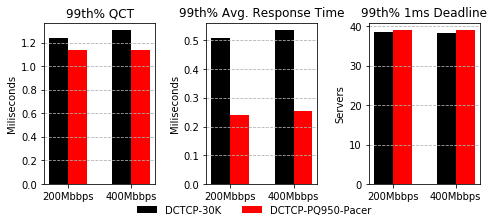

In [239]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(7,3))
config_num = 2
ind = np.arange(config_num)
width = 0.3
x_axis_labels = ('200Mbbps', '400Mbbps')
# qct max
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])
p1 = ax1.bar(ind, res[0], width, color='k')
p2 = ax1.bar(ind+1.0*width, res[1], width, color='r')


ax1.set_title('99th% QCT')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(x_axis_labels)
ax1.set_ylabel('Miliseconds')
ax1.yaxis.grid(linestyle="--")


# qct avg
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_avg[folder]])
p1 = ax2.bar(ind, res[0], width, color='k')
p2 = ax2.bar(ind+1.0*width, res[1], width, color='r')


ax2.set_title('99th% Avg. Response Time')
ax2.set_xticks(ind + width / 2)
ax2.set_xticklabels(x_axis_labels)
ax2.set_ylabel('Miliseconds')
ax2.yaxis.grid(linestyle="--")


# Quality
res = []
for folder in results_folders:
    res.append([x[1] for x in servers_in_deadline[folder]])
p1 = ax3.bar(ind, res[0], width, color='k')
p2 = ax3.bar(ind+1.0*width, res[1], width, color='r')


ax3.set_title('99th% 1ms Deadline')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(x_axis_labels)
ax3.set_ylabel('Servers')
ax3.yaxis.grid(linestyle="--")





fig.legend((p1[0], p2[0]), ('DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.27,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()